In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# !pwd
# import os
# os.chdir('/content/drive/MyDrive/Predicting-Length-OfStay-Of-Patient-In-a-Hospital')
# !pwd

## Healthcare 
## Predicting Hospitalized Time of Covid-19 Patients

### Table of Contents
* [1. Business Understanding](#business_understanding)
* [2. Data Understanding](#data_understanding)
* [3. Data Preparation](#data_preparation)
* [4. Modeling](#modeling)
* [5. Model Evaluation](#model_evaluation)
* [6. Deployment](#deployment)

In [2]:
#!pip install category_encoders
#!pip install mlflow

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# must use: conda install xgboost
# import xgboost as xgb
from xgboost import XGBClassifier

# must use: conda install -c conda-forge category_encoders
from category_encoders import TargetEncoder

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils.np_utils import to_categorical

import pickle
import mlflow
import mlflow.sklearn

from data_preprocessing import *
from config import *
from train_test_classifier import  *

%matplotlib inline

## 1. Business Understanding <a class="anchor" id="business_understanding"></a>

The outbreak of Covid-19 pandemic in 2020 caused tremendous equipment, materials deficiency and beds shortage problems in healthcare system across the U.S. The hospitals not only need to take care of the routine patients, but also need to take care of the sudden increased Covid-19 patients. A good planning and management of a hospital system become very important. 

This project is to use machine-learning techniques to predict how long (how many days) a Covid-19 patient needs to stay in a hospital at the time of admission. This will help hospital professionals to make an optimized planning for patient treatment and resources (e.g., room, bed, etc.) allocation. This also could reduce the amount of hospital visitors to decrease the chance of staff and visitor infection.

## 2. Data Understanding <a class="anchor" id="data_understanding"></a>

Once business understanding is achieved, the next step is to identify where and how to collect the data that can solve the business problem. 
The dataset for this project is obtained from [Kaggle’s website](https://www.kaggle.com/nehaprabhavalkar/av-healthcare-analytics-ii). Three files in the website were used in this project:
1.	Train_data.csv: containing features related to patient, hospital and Length of stay on case basis train
2.	Test_data.csv: containing features related to patient, hospital. Need to predict the “length” of stay for each case id
3.	Train_data_dictionary.csv: containing the information of the features in train and test files.

As shown in the table below, there are 318,438 data samples, total 17 features and 1 label column ("Stay") in this dataset. 

In [4]:
train_data = load_data('train_data.csv')
print(train_data.shape)
train_data.head()

(318438, 18)


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


The definitions of the dataset columns are shown in the following table.

In [5]:
Train_data_dictionary = load_data('train_data_dictionary.csv') 
print(Train_data_dictionary.shape)
Train_data_dictionary.head(18)

(18, 2)


,Column,Description
0,case_id,Case_ID registered in Hospital
1,Hospital_code,Unique code for the Hospital
2,Hospital_type_code,Unique code for the type of Hospital
3,City_Code_Hospital,City Code of the Hospital
4,Hospital_region_code,Region Code of the Hospital
5,Available Extra Rooms in Hospital,Number of Extra rooms available in the Hospital
6,Department,Department overlooking the case
7,Ward_Type,Code for the Ward type
8,Ward_Facility_Code,Code for the Ward Facility
9,Bed Grade,Condition of Bed in the Ward


The following table provides a statistical summary of the numeric features:
* case_id
* Hospital_code
* City_Code_Hospital
* Available Extra Rooms in Hospital
* Bed Grade
* patientid
* City_Code_Patient
* Visitors with Patient
* Admission_Deposit

In [6]:
train_data.describe()

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Visitors with Patient,Admission_Deposit
count,318438.000000,318438.000000,318438.000000,318438.000000,318325.000000,318438.000000,313906.000000,318438.000000,318438.000000
mean,159219.500000,18.318841,4.771717,3.197627,2.625807,65747.579472,7.251859,3.284099,4880.749392
std,91925.276847,8.633755,3.102535,1.168171,0.873146,37979.936440,4.745266,1.764061,1086.776254
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1800.000000
25%,79610.250000,11.000000,2.000000,2.000000,2.000000,32847.000000,4.000000,2.000000,4186.000000
50%,159219.500000,19.000000,5.000000,3.000000,3.000000,65724.500000,8.000000,3.000000,4741.000000
75%,238828.750000,26.000000,7.000000,4.000000,3.000000,98470.000000,8.000000,4.000000,5409.000000
max,318438.000000,32.000000,13.000000,24.000000,4.000000,131624.000000,38.000000,32.000000,11008.000000


The diagram below shows the distribution of the numeric features visually. It can be seen that the case_id feature values are uniformly distributed because they are unique sequential numbers. This feature can be dropped due to lack of prediction power. 

/usr/local/Caskroom/miniforge/base/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'case_id'}>,
        <AxesSubplot:title={'center':'Hospital_code'}>,
        <AxesSubplot:title={'center':'City_Code_Hospital'}>],
       [<AxesSubplot:title={'center':'Available Extra Rooms in Hospital'}>,
        <AxesSubplot:title={'center':'Bed Grade'}>,
        <AxesSubplot:title={'center':'patientid'}>],
       [<AxesSubplot:title={'center':'City_Code_Patient'}>,
        <AxesSubplot:title={'center':'Visitors with Patient'}>,
        <AxesSubplot:title={'center':'Admission_Deposit'}>]], dtype=object)

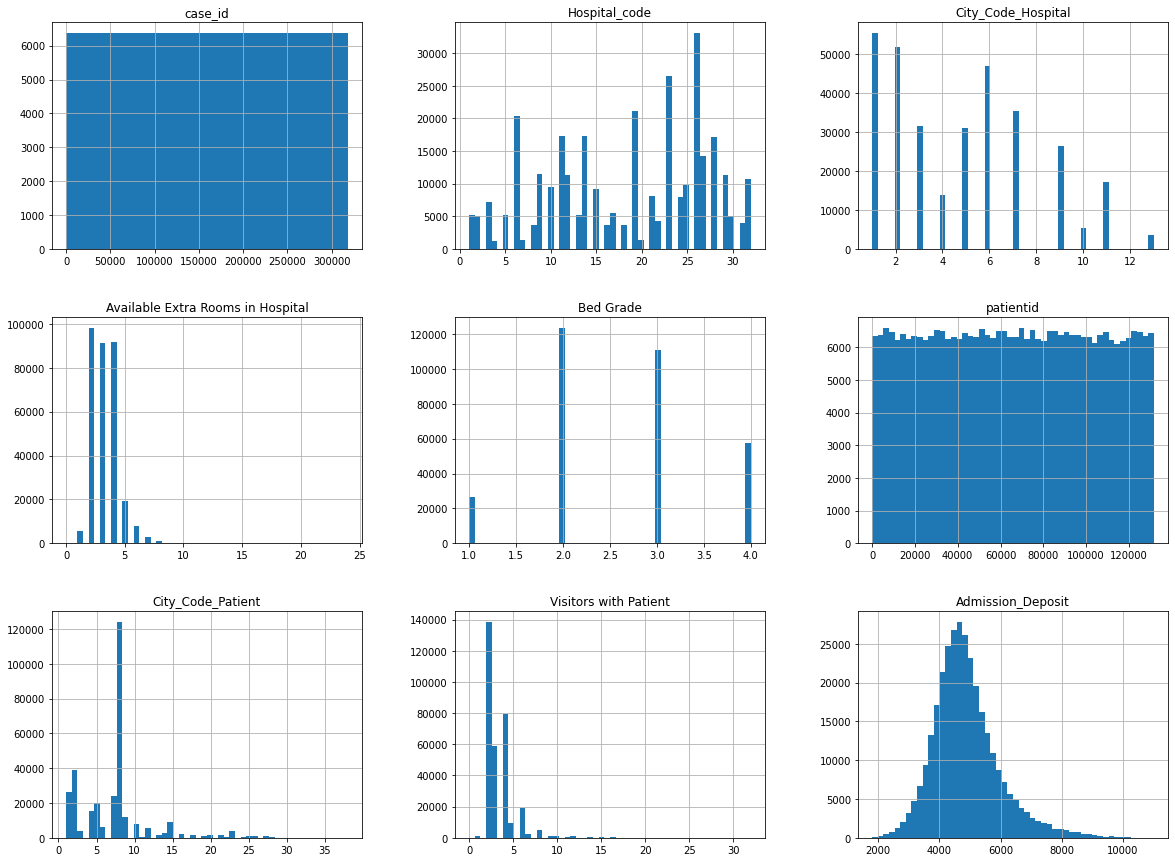

In [7]:
train_data.hist(bins=50, figsize=(20,15))

The following diagram shows the patient visit distribution. We can see that many patients revisited the hospital many times (from 10 up to 50). So patient IDs are important in prediction.

<AxesSubplot:xlabel='patientid'>

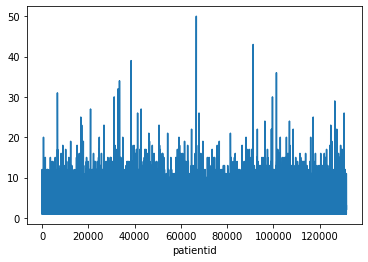

In [8]:
train_data.groupby(['patientid']).count()['case_id'].plot(kind='line')

The diagram below shows the distribution of the categorical features and label column: 
* Hospital type code
* Hospital region code 
* Department
* Ward Type
* Ward Facility Code
* Type of Admission
* Severity of Illness
* Age
* Stay (Label)

We can see that the distribution of the labels is significantly skewed to the right. In other words, the data is not balanced. There are very few data samples in the categories from '41-50' to '61-70'. This will have significant impact on prediction power.


/usr/local/Caskroom/miniforge/base/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


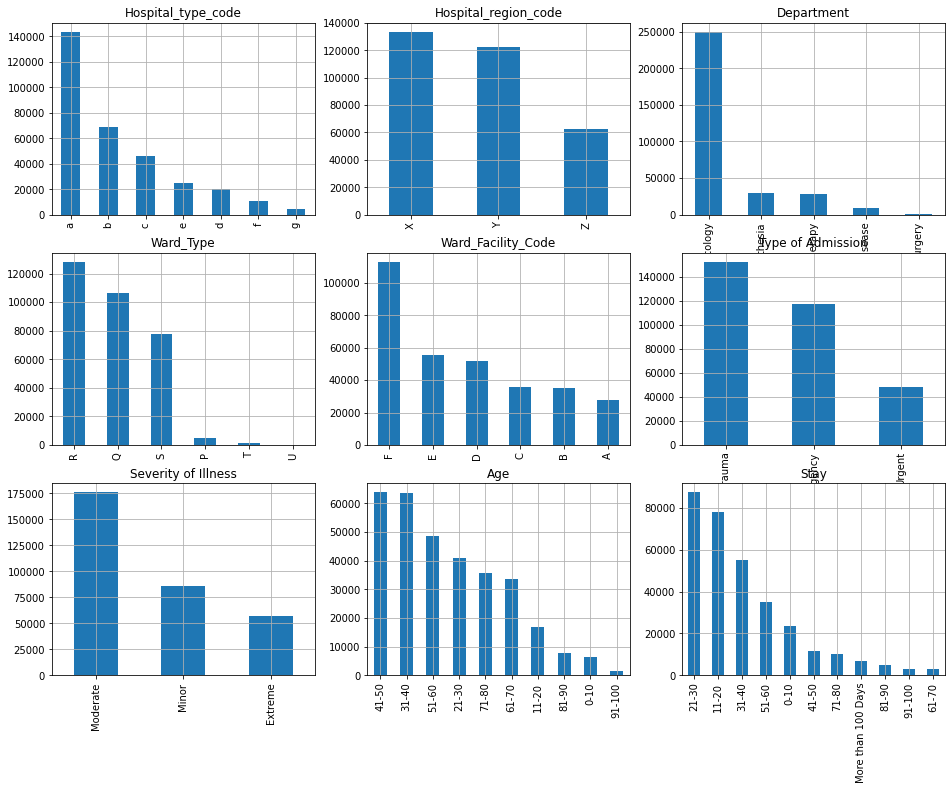

In [9]:
categorical_columns = []
for idx, col in enumerate(train_data.columns):
    # dtypes identify datatype of each column. idx identify each column.
    if train_data.dtypes[idx] == object:
        categorical_columns.append(col)

fig = plt.figure()
for idx, col in enumerate(categorical_columns):
    ax = fig.add_subplot(3, 3, idx + 1)
    train_data[col].value_counts().plot(ax=ax, kind='bar', figsize=(16, 12))
    ax.grid()
    plt.title(col);

The number of data samples in each label category is shown below.

In [10]:
train_data['Stay'].value_counts()

21-30                 87491
11-20                 78139
31-40                 55159
51-60                 35018
0-10                  23604
41-50                 11743
71-80                 10254
More than 100 Days     6683
81-90                  4838
91-100                 2765
61-70                  2744
Name: Stay, dtype: int64

## 3. Data Preparation <a class="anchor" id="data_preparation"></a>

Once the data is understood, the next step is data preparation. The main goal is to explore, clean and transform the collected raw dataset into appropriate format so that the transformed data can be effectively consumed by a target machine learning model.

### 3.1. Handling missing data
As shown in the list below, there are 113 missing data in the 'Bed Grade' feature column and 4,532 missing data in the 'City_Code_Patient' feature column. The total number of missing data is relatively small (4,645) compared with the dataset size of 318,438 rows. In this case we can either drop the rows with missing data or replace with missing data with '0'. I choose to replace the missing data with '0' in order to be able to predict results for data samples with missing data in deployment. Refer to the ```DataCleaning``` class in ```data_preprocessing.py``` for details.

In [11]:
# 3.1 Identify missing data
train_data.isnull().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

### 3.2 Dropping features (columns) without prediction power

As discribed before, the case_id feature doesn't have prediction power, so it is dropped in this project (see the ```DataCleaning``` class in ```data_preprocessing.py``` for details).

### 3.3 Categorical Encoding

#### 3.3.1. Categorical label encoding

The label column "Stay" in this dataset is categorical. It must be transformed into numbers for categorical feature target encoding and deep learning model. The LabelEncoder algorithm is used for the transformation (see ```TargetEncoding``` and ```OneHotEncoding``` classes in ```data_preprocessing.py``` for details).

#### 3.3.2 Categorical feature target encoding

The advantage of target encoding is that it does not increase the dimensionality of the dataset. It has been used for transforming categorical features into numbers for ensemble machine learning models ```XGBoost``` and ```Random Forest``` because these models don't work well with one-hot encoding. See the ```TargetEncoding``` class in ```data_preprocessing.py``` for details.

#### 3.3.3. Categorical feature one-hot encoding

For completeness, the popular one-hot encoding method has been used for transforming categorical features as well for deep learning model (see the ```OneHotEncoding``` class in ```data_preprocessing.py``` for details).

#### 3.3.4. Other categorical feature transformation
I observed that the categorical Age feature (e.g. "21-30") has more prediction power once it is transformed into numbers because the order of ages makes difference. In this project each range of age (e.g., "21-30") has been transformed into an average number of the range like (21+30)/2 = 25.5 (see the ```OneHotEncoding``` class in ```data_preprocessing.py``` for details). 

### 3.4. Feature Normorlization

The numeric features are normalized into the range of ```[-1, 1]``` for deep learning (see the ```FeatureNormorlization``` class in ```data_preprocessing.py``` for details).

### 3.5. Data Splitting

Finally, the preprocessed dataset is splitted into two subsets: one for model training and the other for model evaluation.

### 3.6. Data Preprocessing Pipelines

The data preparation steps 3.1 - 3.5 have been combined into data preprocessing pipelines for convenience:
* target_encoding_preprocessing
* target_encoding_preprocessing_for_prediction
* onehot_encoding_preprocessing
* onehot_encoding_preprocessing_for_prediction

See ```data_preprocessing.py``` for details.

## 4. Modeling <a class="anchor" id="modeling"></a>

After data preparation, we are ready for modeling. The main goals of modeling include:
* Identify potential machine learning models
* Train models and tune the hyper-parameters of models

### 4.1. Model Selection

This project is to address a multi-classes classification issue because the label is categorical with more than 2 categories. This is suitable for supervised machine learning classification models such as XGBoost, Random Forest, deep learning MLP classifiers. 

Because the data is in tabular format and the number of features is relatively small, XGBoost and Random Forest are generally preferred compared with deep learning models. 

In this project XGBoost, Random Forest, and MLP classifiers are selected for experiments.

### 4.2. Model Training and Hyper-Parameters Tuning

Both XGBoost and Random Forest model training are performed with 10 folder cross validation. Grid search is used for selecting the best combination of hyper-parameters. Cross validation is also used for training the deep learning model. See the following functions in ```train_test_classifier.py```:
* build_xgboost_model
* build_rf_model
* build_deeplearning_model

## 5. Model Evaluation <a class="anchor" id="model_evaluation"></a>

Once different machine learning models have been trained, the performance of these models needs to be evaluated so that we can select the best model for deployment. The classification accuracy, F1 score, and confusion matrix are used as the main evaluation metrics for this project. Refer to the following functions in ```train_test_classifier.py``` for details:
* evaluate_xgboost_model
* evaluate_rf_model
* evaluate_dl_model

Typically the accuracy is not a good metric in the case of binary classification with imbalanced data because it can easily achieve high percentage of accuracy by simply predicting the majority class. However this is not necessary the case in multi-classes classification. For example, in the dataset for this project, there are only 87,491 data samples for the majority class 21-30. The total number of data samples is 318,438. If a model always predicts the majority class, the accuracy would be about 27.5%. Thus the accuracy can still be a good model performance measurement in the case of multi-classes classification since it represents the average accuracy of classifications of different label classes. 

In addition to accuracy, F1 score is used to measure both XGBoost and Random Forest model performance as well since it can measure the balance of precision and recall, which is suitable for imbalanced data. 

The confusion matrix is used because it can clearly tell us what prediction mistakes a model made.

### 5.1. MLFlow

In order to effectively tracking model hyper-parameters and performance metrics, the MLFlow tool is used. In particular, I developed the function ```mlFlow()``` in ```train_test_classifier.py``` to combine the following activities into one procedure:
* Loading training data
* Preprocessing data
* Training model
* Evaluating model

As an example, the following are the results of running the mlFlow() function for a XGBoost model. 


LOAD TRAINING DATA: train_data.csv


DATA PROCESSING: 

DataCleaning.fit ...
DataCleaning.transform ...
TargetEncoding.fit ...
TargetEncoding.transform ...
FeatureNormorlization.fit ...
FeatureNormorlization.transform ...

Find the correlations between each feature and label (Stay):

Hospital_code                        0.042846
Hospital_type_code                   0.081934
City_Code_Hospital                   0.006381
Hospital_region_code                 0.012519
Available Extra Rooms in Hospital   -0.121120
Department                           0.037659
Ward_Type                            0.192538
Ward_Facility_Code                   0.083998
Bed Grade                            0.025520
patientid                            0.001125
City_Code_Patient                   -0.011148
Type of Admission                    0.092205
Severity of Illness                  0.126245
Visitors with Patient                0.537537
Age                                  0.097407
Admission_Deposit       

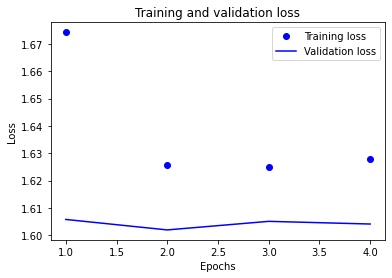

INFO:tensorflow:Assets written to: ram://368174ca-fffa-4896-88f0-55f8a040bb9b/assets

 ML FLOW DONE. 



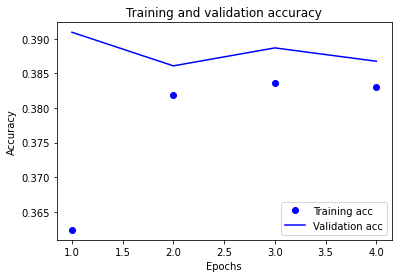

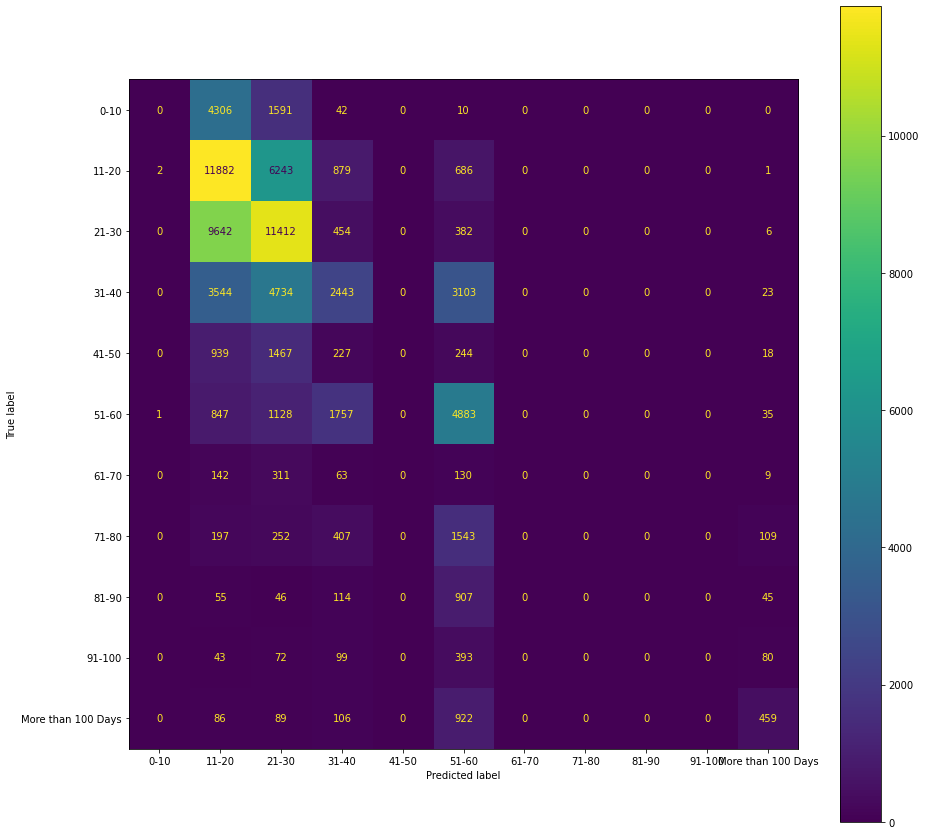

In [12]:
target_encoders, label_encoder = mlFlow()

The following screenshot shows the results of four model evaluations:
* XGBoost with target encoding
* Random Forest with target encoding
* MLP with target encoding
* MLP with one-hot encoding

We can see that XGBoost has the best performance in accuracy for the given dataset and so we can select it for deployment if the performance meets business requirements.

<img src="/Users/parthamehta/python-workspace/Predicting-Length-OfStay-Of-Patient-In-a-Hospital/images/mlflow.png" width="50%"/>

As shown in the above screenshot, the best accuracy score is only about 42.4%. This is because there are too little data in the majority of the labeled categories such as the following ranges: ```41-50```, from ```61-70``` all way up to ```more than 100```. 

The accuracy score will increase if more data can be collected to balance the dataset. As an experiment, I selected only the data samples in the categories of ```11-20``` and ```21-30``` and observed that the accuracy score was increased to about 63%. The following diagram shows the corresponding confusion matrix from a trained Random Forest model.

<img src="/Users/parthamehta/python-workspace/Predicting-Length-OfStay-Of-Patient-In-a-Hospital/images/rf_filtered_confusion_matrix.png" width="50%"/>

In order to understand how different features impacted the prediction, the following diagram shows the feature importance produced by a trained Random Forest model.

<img src="/Users/parthamehta/python-workspace/Predicting-Length-OfStay-Of-Patient-In-a-Hospital/images/features_importance.png" width="50%"/>

I also looked into the correlations between the features and the target labels as shown in the table below. 

| Features | Correlation Coefficient |
| --- | --- |
| Hospital_code  | 0.042846 |
| Hospital_type_code | 0.081934 |
| City_Code_Hospital | 0.006381 |
| Hospital_region_code | 0.012519 |
| Available Extra Rooms in Hospital | -0.121120 |
| Department | 0.037659 |
| Ward_Type  | 0.192538 |
| Ward_Facility_Code | 0.083998 |
| Bed Grade | 0.025520 |
| patientid | 0.001125 |
| City_Code_Patient | -0.011148 |
| Type of Admission | 0.092205 |
| Severity of Illness | 0.126245 |
| Visitors with Patient | 0.537537 |
| Age  | 0.097407 |
| Admission_Deposit | -0.052077 |
| Stay | 1.000000 |

It is tricky to use correlation coefficient to determine the strength of relationship between a feature and the target because the correlation coefficient only indicates linear relationship. A feature (e.g., patientid) with very low correlation coefficient does not necessary indicate that there is no relationship between the feature and the target. For example, the ```patient id``` has very small correlation coefficient, but its feature importance is high. 

I tried to remove some of the features with low feature importance (e.g., Hospital_region_code, City_Code_Hospital, etc.) and features with very small correlation coefficients (e.g., City_Code_Hospital) and observed that it didn't help to increase accuracy score. 

## 6. Deployment <a class="anchor" id="deployment"></a>

Once the best model has been identified for deployment in model evaluation, we can move to the final step to deploy the identified model into a production system. One common deployment method is to deploy the model as a Web service on a server, which can be called by other components in a target production system to get prediction results. 

In order to support deployment, both the selected trained model (e.g., XGBoost) and the related encoding objects (e.g., LabelEncoder object, TargetEncoder objects) are saved into Python pickle files after model training. These saved encoding objects and model are loaded back for prediction in deployment.

As an example, the following code loads in the provided ```test_data.csv``` for prediction at deployment. Note that this dataset does not have the label column 'Stay'.

In [15]:
test_data = load_data('test_data.csv')
print(test_data.shape)
test_data.transpose().head(100)

(137057, 17)


,0,1,2,3,4,5,6,7,8,9,...,137047,137048,137049,137050,137051,137052,137053,137054,137055,137056
case_id,318439,318440,318441,318442,318443,318444,318445,318446,318447,318448,...,455486,455487,455488,455489,455490,455491,455492,455493,455494,455495
Hospital_code,21,29,26,6,28,23,26,25,23,23,...,9,13,12,13,15,11,25,30,5,6
Hospital_type_code,c,a,b,a,b,a,b,e,a,a,...,d,a,a,a,c,b,e,c,a,a
City_Code_Hospital,3,4,2,6,11,6,2,1,6,6,...,5,5,9,5,5,2,1,3,1,6
Hospital_region_code,Z,X,Y,X,X,X,Y,X,X,X,...,Z,Z,Y,Z,Z,Y,X,Z,X,X
Available Extra Rooms in Hospital,3,2,3,3,2,3,2,4,4,3,...,2,2,6,3,2,4,2,2,2,3
Department,gynecology,gynecology,gynecology,gynecology,gynecology,gynecology,gynecology,gynecology,gynecology,gynecology,...,gynecology,gynecology,gynecology,gynecology,gynecology,anesthesia,radiotherapy,anesthesia,anesthesia,gynecology
Ward_Type,S,S,Q,Q,R,Q,Q,S,Q,Q,...,S,R,Q,R,S,Q,R,R,R,Q
Ward_Facility_Code,A,F,D,F,F,F,D,E,F,F,...,F,F,B,F,F,D,E,A,E,F
Bed Grade,2.0,2.0,4.0,2.0,2.0,2.0,2.0,3.0,3.0,4.0,...,4.0,3.0,2.0,3.0,4.0,3.0,4.0,4.0,4.0,4.0


The code below does the following:
* loading the saved model and encoding objects
* using them to predict the number of hospitalized days for each of the patients in the test dataset
* showing the first 100 records in the resulting dataframe with the features and predicted labels (the 'Stay' column)
* displaying the distribution of the predicted labels. 

We can see that the pattern of the predicted labels is very similar to the pattern of the labels in the train_data.csv file. 

DataCleaning.fit ...
DataCleaning.transform ...
TargetEncodingForPrediction.fit ...
TargetEncodingForPrediction.transform ...
FeatureNormorlization.fit ...
FeatureNormorlization.transform ...


,0,1,2,3,4,5,6,7,8,9,...,137047,137048,137049,137050,137051,137052,137053,137054,137055,137056
case_id,318439,318440,318441,318442,318443,318444,318445,318446,318447,318448,...,455486,455487,455488,455489,455490,455491,455492,455493,455494,455495
Hospital_code,21,29,26,6,28,23,26,25,23,23,...,9,13,12,13,15,11,25,30,5,6
Hospital_type_code,c,a,b,a,b,a,b,e,a,a,...,d,a,a,a,c,b,e,c,a,a
City_Code_Hospital,3,4,2,6,11,6,2,1,6,6,...,5,5,9,5,5,2,1,3,1,6
Hospital_region_code,Z,X,Y,X,X,X,Y,X,X,X,...,Z,Z,Y,Z,Z,Y,X,Z,X,X
Available Extra Rooms in Hospital,3,2,3,3,2,3,2,4,4,3,...,2,2,6,3,2,4,2,2,2,3
Department,gynecology,gynecology,gynecology,gynecology,gynecology,gynecology,gynecology,gynecology,gynecology,gynecology,...,gynecology,gynecology,gynecology,gynecology,gynecology,anesthesia,radiotherapy,anesthesia,anesthesia,gynecology
Ward_Type,S,S,Q,Q,R,Q,Q,S,Q,Q,...,S,R,Q,R,S,Q,R,R,R,Q
Ward_Facility_Code,A,F,D,F,F,F,D,E,F,F,...,F,F,B,F,F,D,E,A,E,F
Bed Grade,2.0,2.0,4.0,2.0,2.0,2.0,2.0,3.0,3.0,4.0,...,4.0,3.0,2.0,3.0,4.0,3.0,4.0,4.0,4.0,4.0


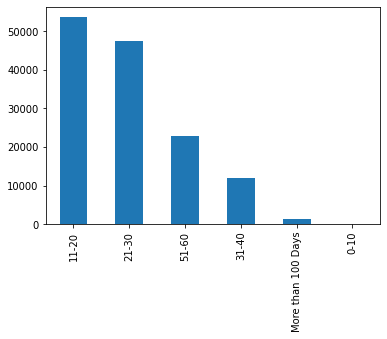

In [16]:
label_encoder, target_encoders = load_encoders()
result_df = predict(label_encoder, target_encoders, test_data_file='test_data.csv')
result_df['Stay'].value_counts().plot(kind='bar')
result_df.transpose().head(100)